# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

2025-05-18 06:02:02.240334: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 06:02:02.811406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 06:02:03.359403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747548124.112795    2283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747548124.261442    2283 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747548125.660543    2283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Data Ingestion
## Ingesting Data from API -> MongoDB -> Pandas DataFrame

In [2]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv 
import pandas as pd  
load_dotenv() 
PYMONGO_URI = os.getenv("PYMONGO_URI")
API_URI = os.getenv("API_URI")

# Connect to the MongoDB client
client = MongoClient(PYMONGO_URI, tls=True)
db = client['bitcoin_crypto_data']
collection = db['bitcoin_historical_data']
 
try: 
    data = list(collection.find())   
    df = pd.DataFrame(data)  
    if '_id' in df.columns:
        df = df.drop(columns=['_id']) 
    print(df) 
except Exception as e:
    print(f"An error occurred: {e}") 

python-dotenv could not parse statement starting at line 8
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12


     UNIT   TIMESTAMP TYPE MARKET INSTRUMENT           OPEN           HIGH  \
0     DAY  1317340800  267  cadli    BTC-USD       4.788839       5.308179   
1     DAY  1318291200  267  cadli    BTC-USD       4.101192       4.103590   
2     DAY  1318896000  267  cadli    BTC-USD       2.564704       2.882134   
3     DAY  1320019200  267  cadli    BTC-USD       3.269974       3.314105   
4     DAY  1321488000  267  cadli    BTC-USD       2.559723       2.579895   
...   ...         ...  ...    ...        ...            ...            ...   
4995  DAY  1745884800  267  cadli    BTC-USD   95039.773549   95479.643867   
4996  DAY  1745971200  267  cadli    BTC-USD   94298.769728   95256.576007   
4997  DAY  1746489600  267  cadli    BTC-USD   94862.008664   96943.828464   
4998  DAY  1746576000  267  cadli    BTC-USD   96866.220284   97708.055510   
4999  DAY  1747094400  267  cadli    BTC-USD  102801.528591  104972.901638   

                LOW          CLOSE  FIRST_MESSAGE_TIMESTAMP  ..

# Exploratory Data Analysis

In [37]:
df.shape

(5000, 27)

In [38]:
len(df)

5000

In [39]:
df.head()

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
0,DAY,1317340800,267,cadli,BTC-USD,4.788839,5.308179,4.745791,5.140630,1317340980,...,931,42699.737202,214302.165021,42699.737202,214302.165021,41459.069455,208038.786801,41459.069455,208038.786801,2011-09-30
1,DAY,1318291200,267,cadli,BTC-USD,4.101192,4.103590,3.853023,3.951453,1318291320,...,852,43275.627511,171031.376246,43275.627511,171031.376246,41104.077169,162268.540852,41104.077169,162268.540852,2011-10-11
2,DAY,1318896000,267,cadli,BTC-USD,2.564704,2.882134,2.312264,2.419010,1318896000,...,979,91528.591539,239482.758213,91528.591539,239482.758213,87859.091704,229826.441668,87859.091704,229826.441668,2011-10-18
3,DAY,1320019200,267,cadli,BTC-USD,3.269974,3.314105,3.066025,3.247988,1320019200,...,888,32099.911936,102277.778512,32099.911936,102277.778512,30980.524908,98715.595295,30980.524908,98715.595295,2011-10-31
4,DAY,1321488000,267,cadli,BTC-USD,2.559723,2.579895,2.115849,2.250467,1321488000,...,971,100956.507375,229595.784291,100956.507375,229595.784291,94837.321662,215385.548236,94837.321662,215385.548236,2011-11-17


In [40]:
df.tail()

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
4995,DAY,1745884800,267,cadli,BTC-USD,95039.773549,95479.643867,93797.110420,94298.769728,1745884800,...,874715,179941.908855,1.706720e+10,92829.111155,8.806089e+09,21542.721382,2.043894e+09,17521.347825,1.662658e+09,2025-04-29
4996,DAY,1745971200,267,cadli,BTC-USD,94298.769728,95256.576007,93017.834736,94210.990854,1745971200,...,803134,185579.588635,1.750781e+10,103230.329996,9.735107e+09,25890.688394,2.439996e+09,22114.148580,2.083752e+09,2025-04-30
4997,DAY,1746489600,267,cadli,BTC-USD,94862.008664,96943.828464,93460.715271,96866.220284,1746489600,...,878624,173642.623255,1.645068e+10,96055.907664,9.102304e+09,22784.561503,2.157437e+09,18978.824129,1.796991e+09,2025-05-06
4998,DAY,1746576000,267,cadli,BTC-USD,96866.220284,97708.055510,95848.264474,97073.375512,1746576000,...,930291,182380.131449,1.766421e+10,96504.816721,9.345807e+09,24380.492344,2.360430e+09,20481.543229,1.982805e+09,2025-05-07
4999,DAY,1747094400,267,cadli,BTC-USD,102801.528591,104972.901638,101483.838703,104119.197358,1747094400,...,271417,217821.587436,2.252329e+10,108306.608587,1.120183e+10,25902.996897,2.682768e+09,20963.955428,2.172031e+09,2025-05-13


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   UNIT                          5000 non-null   object        
 1   TIMESTAMP                     5000 non-null   int64         
 2   TYPE                          5000 non-null   object        
 3   MARKET                        5000 non-null   object        
 4   INSTRUMENT                    5000 non-null   object        
 5   OPEN                          5000 non-null   float64       
 6   HIGH                          5000 non-null   float64       
 7   LOW                           5000 non-null   float64       
 8   CLOSE                         5000 non-null   float64       
 9   FIRST_MESSAGE_TIMESTAMP       5000 non-null   int64         
 10  LAST_MESSAGE_TIMESTAMP        5000 non-null   int64         
 11  FIRST_MESSAGE_VALUE           

In [42]:
df.describe()

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP,FIRST_MESSAGE_VALUE,HIGH_MESSAGE_VALUE,HIGH_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,...,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5000.000000,5.000000e+03,5000
mean,1.531397e+09,17281.991734,17681.261049,16866.442239,17302.794493,1.531397e+09,1.531483e+09,17281.624358,17681.015017,1.531439e+09,...,1.406243e+05,2.748141e+05,6.746727e+09,1.324830e+05,3.366310e+09,61484.916965,1.054725e+09,50256.314015,7.976498e+08,2018-07-12 12:00:00
min,1.315440e+09,2.050135,2.249777,2.001710,2.050135,1.315440e+09,1.315526e+09,2.113384,2.249777,1.315440e+09,...,2.470000e+02,1.054983e+03,2.983975e+04,7.756034e+02,2.983975e+04,775.603431,2.888803e+04,775.603431,2.888803e+04,2011-09-08 00:00:00
25%,1.423418e+09,391.596754,407.906074,378.589229,392.038706,1.423418e+09,1.423505e+09,392.042267,407.906074,1.423431e+09,...,1.427000e+03,5.267332e+04,1.171814e+07,4.125951e+04,1.040312e+07,27103.455822,9.876018e+06,22065.644137,9.613345e+06,2015-02-08 18:00:00
50%,1.531397e+09,6462.552506,6583.344730,6369.263203,6467.647525,1.531397e+09,1.531483e+09,6460.414804,6581.940151,1.531430e+09,...,1.440000e+03,2.027462e+05,1.604003e+09,9.649730e+04,6.366151e+08,46355.992922,3.069448e+08,37176.278119,2.238842e+08,2018-07-12 12:00:00
75%,1.639375e+09,27007.159350,27430.272615,26671.899532,27033.562543,1.639375e+09,1.639462e+09,26998.303263,27430.272615,1.639395e+09,...,1.440000e+03,3.748556e+05,1.117205e+10,1.755483e+05,4.984816e+09,78825.663964,1.422304e+09,62433.329670,9.894248e+08,2021-12-13 06:00:00
max,1.747354e+09,106188.135939,109134.786742,105395.742955,106188.135939,1.747354e+09,1.747377e+09,106188.135791,109134.786742,1.747363e+09,...,2.054717e+06,3.137129e+06,1.047658e+11,1.503283e+06,7.652634e+10,614241.111991,1.435622e+10,598191.019798,1.229354e+10,2025-05-16 00:00:00
std,1.247201e+08,24322.564165,24834.932614,23799.117548,24352.248981,1.247201e+08,1.247201e+08,24323.268302,24834.817829,1.247214e+08,...,4.068029e+05,2.929089e+05,1.009233e+10,1.350552e+05,5.622004e+09,54127.933451,1.700373e+09,46220.078647,1.386625e+09,NaN


### Missing Values
#### Checking null values

In [43]:
df.isnull().sum()

UNIT                            0
TIMESTAMP                       0
TYPE                            0
MARKET                          0
INSTRUMENT                      0
OPEN                            0
HIGH                            0
LOW                             0
CLOSE                           0
FIRST_MESSAGE_TIMESTAMP         0
LAST_MESSAGE_TIMESTAMP          0
FIRST_MESSAGE_VALUE             0
HIGH_MESSAGE_VALUE              0
HIGH_MESSAGE_TIMESTAMP          0
LOW_MESSAGE_VALUE               0
LOW_MESSAGE_TIMESTAMP           0
LAST_MESSAGE_VALUE              0
TOTAL_INDEX_UPDATES             0
VOLUME                          0
QUOTE_VOLUME                    0
VOLUME_TOP_TIER                 0
QUOTE_VOLUME_TOP_TIER           0
VOLUME_DIRECT                   0
QUOTE_VOLUME_DIRECT             0
VOLUME_TOP_TIER_DIRECT          0
QUOTE_VOLUME_TOP_TIER_DIRECT    0
DATE                            0
dtype: int64

# Data Cleaning

In [44]:
# Dropping Unnecessary columns 
columns_to_drop = [
            'UNIT','TIMESTAMP', 'VOLUME', 'QUOTE_VOLUME',
            'TYPE', 'MARKET', 'INSTRUMENT', 
            'FIRST_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_TIMESTAMP', 
            'FIRST_MESSAGE_VALUE', 'HIGH_MESSAGE_VALUE', 'HIGH_MESSAGE_TIMESTAMP', 
            'LOW_MESSAGE_VALUE', 'LOW_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_VALUE', 
            'TOTAL_INDEX_UPDATES', 'VOLUME_TOP_TIER', 'QUOTE_VOLUME_TOP_TIER', 
            'VOLUME_DIRECT', 'QUOTE_VOLUME_DIRECT', 'VOLUME_TOP_TIER_DIRECT', 
            'QUOTE_VOLUME_TOP_TIER_DIRECT' 
        ]

cleaned_data = df.drop(columns=columns_to_drop, errors='ignore')

cleaned_data = cleaned_data.set_index('DATE').sort_index()

In [45]:
cleaned_data.shape

(5000, 4)

In [46]:
cleaned_data.head()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2011-09-08,7.186523,7.196992,6.526702,6.526702
2011-09-09,6.526702,6.526702,4.260291,5.031691
2011-09-10,5.031691,5.436745,4.650752,4.773901
2011-09-11,4.773901,7.088052,4.538431,4.895557
2011-09-12,4.895557,6.187760,4.895557,6.054304


In [47]:
#Close price data
closing_price = cleaned_data[['CLOSE']] 
closing_price

,CLOSE
DATE,
2011-09-08,6.526702
2011-09-09,5.031691
2011-09-10,4.773901
2011-09-11,4.895557
2011-09-12,6.054304
...,...
2025-05-12,102801.528591
2025-05-13,104119.197358
2025-05-14,103525.737928


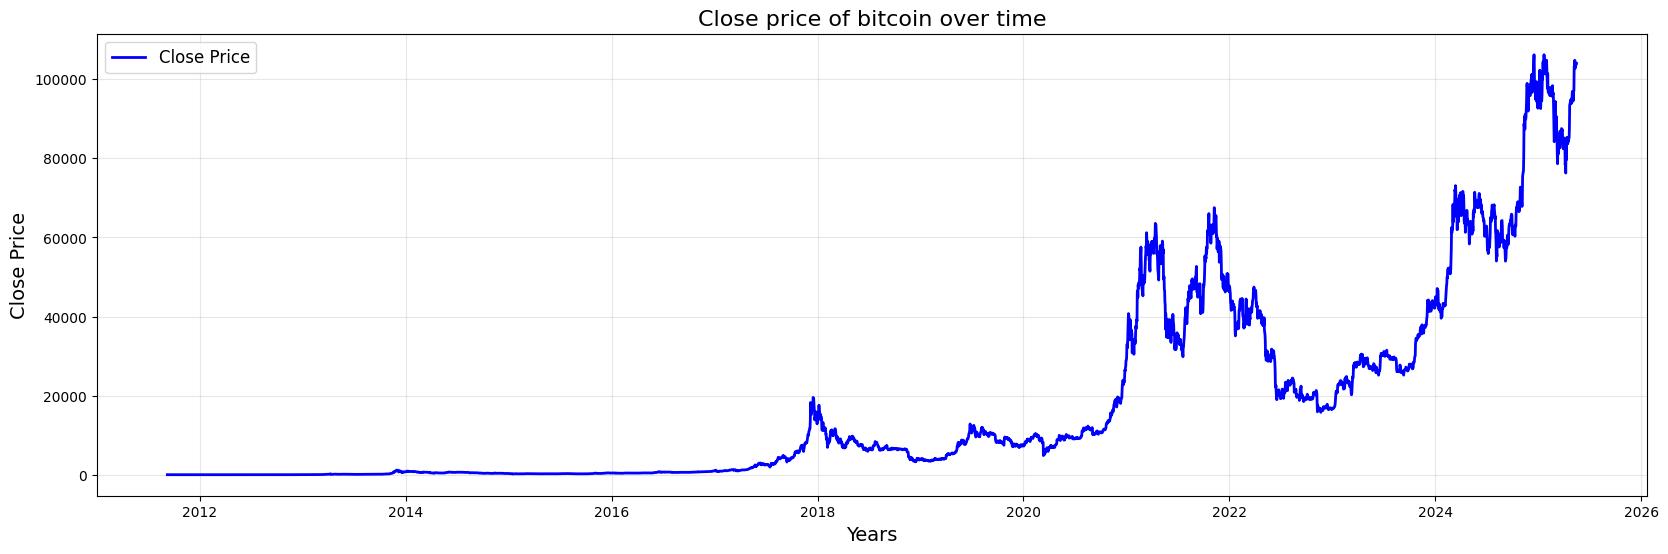

In [48]:
#Plot closing price with enchacement
plt.figure(figsize = (20, 6))
plt.plot(closing_price.index, closing_price['CLOSE'], label = 'Close Price', color = 'blue', linewidth =2)
plt.title("Close price of bitcoin over time", fontsize = 16)
plt.xlabel("Years", fontsize = 14)
plt.ylabel('Close Price', fontsize = 14)
plt.grid(alpha = 0.3)
plt.legend(fontsize = 12)
plt.show()

In [49]:
for i in range(2011, 2026):
    print(i, list(closing_price.index.year).count(i))

2011 115
2012 366
2013 365
2014 365
2015 365
2016 366
2017 365
2018 365
2019 365
2020 366
2021 365
2022 365
2023 365
2024 366
2025 136


In [50]:
closing_price['MA_365'] = closing_price['CLOSE'].rolling(window = 365).mean()
closing_price['MA_100'] = closing_price['CLOSE'].rolling(window = 100).mean()

/tmp/ipykernel_2283/1996534189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closing_price['MA_365'] = closing_price['CLOSE'].rolling(window = 365).mean()
/tmp/ipykernel_2283/1996534189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closing_price['MA_100'] = closing_price['CLOSE'].rolling(window = 100).mean()


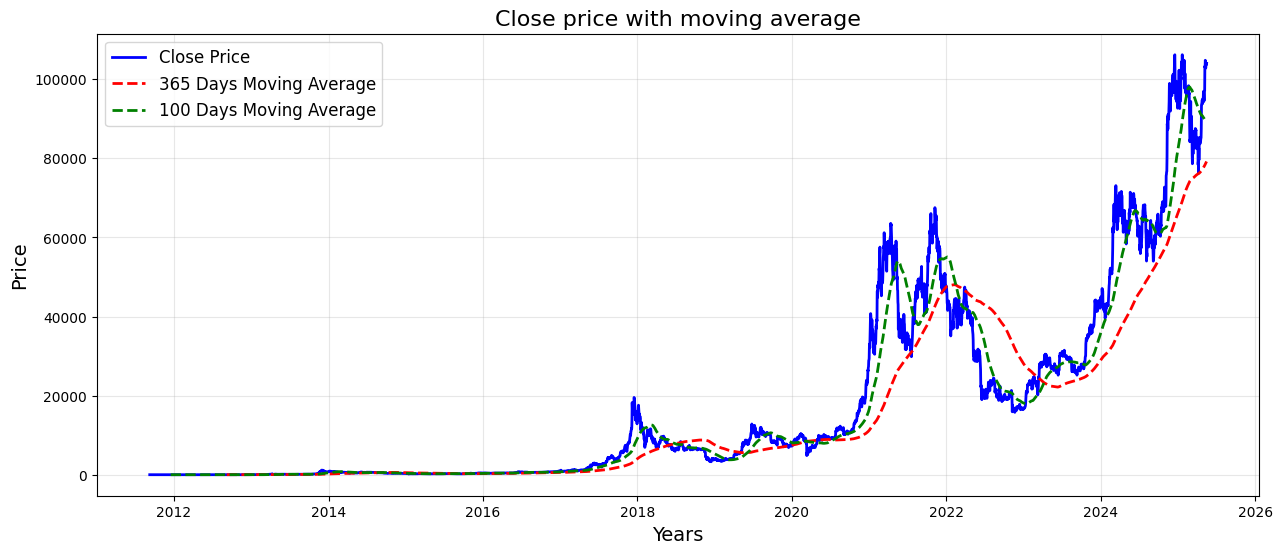

In [51]:
#Plot closing price with enchacement
plt.figure(figsize = (15, 6))
plt.plot(closing_price.index, closing_price['CLOSE'], label = 'Close Price', color = 'blue', linewidth =2)
plt.plot(closing_price.index, closing_price['MA_365'], label = '365 Days Moving Average', color = 'red', linestyle ="--", linewidth =2)
plt.plot(closing_price.index, closing_price['MA_100'], label = '100 Days Moving Average', color = 'green',linestyle ="--", linewidth =2)

plt.title("Close price with moving average", fontsize = 16)
plt.xlabel("Years", fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.grid(alpha = 0.3)
plt.legend(fontsize = 12)
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_price[['CLOSE']].dropna())

In [25]:
len(scaled_data)

5000

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
# Prepare data for lstm
x_data = []
y_data = []
base_days =100
for i in range(base_days, len(scaled_data)):
    x_data.append(scaled_data[i-base_days: i])
    y_data.append(scaled_data[i])
x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape,y_data.shape)

(4900, 100, 1) (4900, 1)


In [29]:
# Split into train and test sets
train_size = int(len(x_data) * 0.9)
x_train , y_train = x_data[:train_size], y_data[:train_size]
x_test, y_test = x_data[train_size:], y_data[train_size:]
print(train_size)
print(x_train.shape,y_train.shape, x_test.shape,y_test.shape)

4410
(4410, 100, 1) (4410, 1) (490, 100, 1) (490, 1)


In [30]:
model = Sequential([
    LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], 1)),
    LSTM(64, return_sequences = False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

2025-05-18 06:10:29.774243: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.fit(x_train, y_train, batch_size = 5, epochs = 10)

Epoch 1/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 173s 186ms/step - loss: 5.7206e-04
Epoch 2/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 159s 180ms/step - loss: 2.1168e-04
Epoch 3/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 161s 182ms/step - loss: 1.1521e-04
Epoch 4/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 159s 180ms/step - loss: 9.3282e-05
Epoch 5/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 162s 181ms/step - loss: 1.0514e-04
Epoch 6/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 163s 184ms/step - loss: 8.9832e-05
Epoch 7/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 164s 186ms/step - loss: 1.0645e-04
Epoch 8/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 162s 184ms/step - loss: 8.8217e-05
Epoch 9/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 166s 188ms/step - loss: 9.4671e-05
Epoch 10/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 163s 185ms/step - loss: 7.5092e-05


In [32]:
y_pred = model.predict(x_test)
inv_y_pred = scaler.inverse_transform(y_pred)
inv_y_test = scaler.inverse_transform(y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step


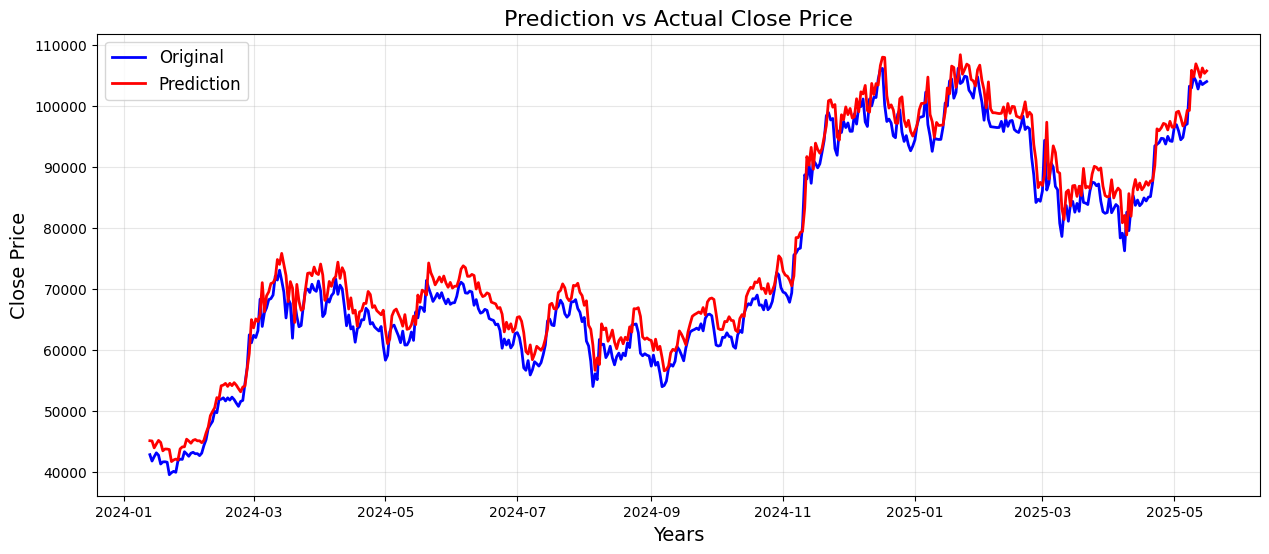

In [33]:
plotting_data = pd.DataFrame(
    {
        'Original': inv_y_test.flatten(), 
        'Prediction': inv_y_pred.flatten(),
    }, index = closing_price.index[train_size + base_days:]
)

plt.figure(figsize = (15, 6))
plt.plot(plotting_data.index, plotting_data['Original'], label = 'Original', color = 'blue', linewidth =2)
plt.plot(plotting_data.index, plotting_data['Prediction'], label = 'Prediction', color = 'red',  linewidth =2)

plt.title("Prediction vs Actual Close Price", fontsize = 16)
plt.xlabel("Years", fontsize = 14)
plt.ylabel('Close Price', fontsize = 14)
plt.grid(alpha = 0.3)
plt.legend(fontsize = 12)
plt.show()

In [34]:
# Predict future days
last_100  = scaled_data[-100:].reshape(1, -1, 1)
future_predictions=[]
for _ in range(10):
    next_days = model.predict(last_100)
    future_predictions.append(scaler.inverse_transform(next_days))
    last_100 = np.append(last_100[:, 1:, :], next_days.reshape(1, 1, -1), axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [35]:
future_predictions

[array([[105948.33]], dtype=float32),
 array([[107963.13]], dtype=float32),
 array([[109833.92]], dtype=float32),
 array([[111592.68]], dtype=float32),
 array([[113251.51]], dtype=float32),
 array([[114804.44]], dtype=float32),
 array([[116243.5]], dtype=float32),
 array([[117564.62]], dtype=float32),
 array([[118768.47]], dtype=float32),
 array([[119859.336]], dtype=float32)]

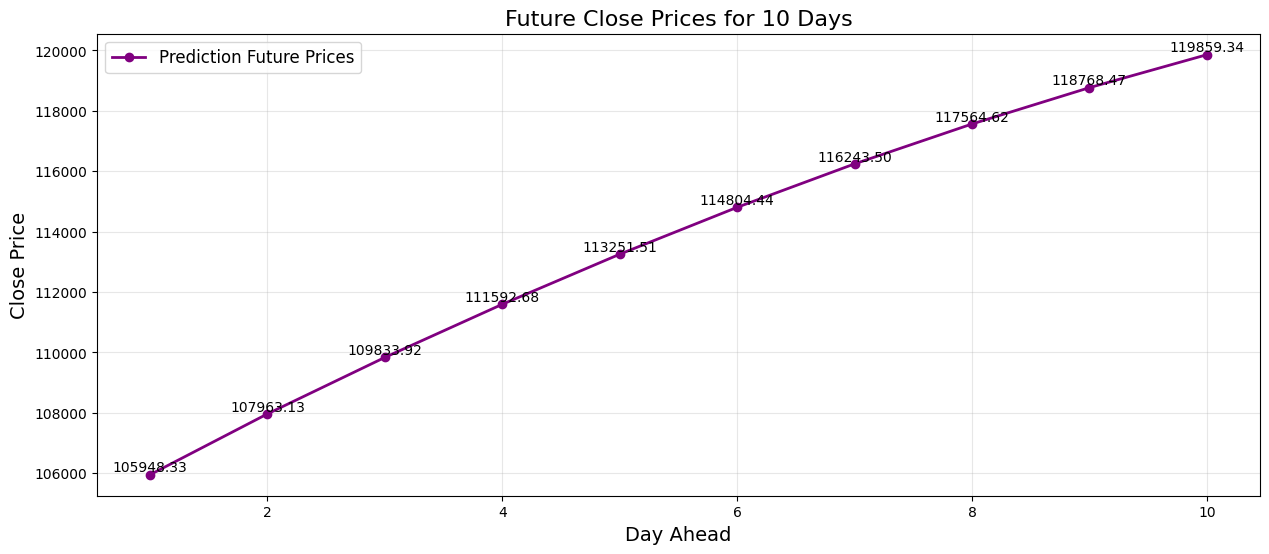

In [36]:
future_predictions = np.array(future_predictions).flatten()

plt.figure(figsize = (15, 6))
plt.plot(range(1, 11), future_predictions, marker="o" ,label = 'Prediction Future Prices', color = 'purple', linewidth =2)

for i, val in enumerate(future_predictions):
    plt.text(i+1,val,  f'{val:.2f}', fontsize = 10, ha = 'center', va = 'bottom', color='black')

plt.title("Future Close Prices for 10 Days", fontsize = 16)
plt.xlabel("Day Ahead", fontsize = 14)
plt.ylabel('Close Price', fontsize = 14)
plt.grid(alpha = 0.3)
plt.legend(fontsize = 12)
plt.show()

# Feature Engineering

In [54]:
cleaned_data = closing_price.copy() 

In [56]:
cleaned_data['SMA_20'] = cleaned_data['CLOSE'].rolling(window=20).mean()
cleaned_data['SMA_50'] = cleaned_data['CLOSE'].rolling(window=50).mean()
cleaned_data['EMA_20'] = cleaned_data['CLOSE'].ewm(span=20, adjust=False).mean()
 
# Lagged features 
cleaned_data['CLOSE_lag1'] = cleaned_data['CLOSE'].shift(1) 

# Rolling statistics
cleaned_data['CLOSE_roll_mean_14'] = cleaned_data['CLOSE'].rolling(window=14).mean()
cleaned_data['CLOSE_roll_std_14']  = cleaned_data['CLOSE'].rolling(window=14).std()

# Log transform for the target
cleaned_data['LogClose'] = np.log1p(cleaned_data['CLOSE'])



In [57]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2011-09-08 to 2025-05-16
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CLOSE               5000 non-null   float64
 1   MA_365              4636 non-null   float64
 2   MA_100              4901 non-null   float64
 3   SMA_20              4981 non-null   float64
 4   SMA_50              4951 non-null   float64
 5   EMA_20              5000 non-null   float64
 6   CLOSE_lag1          4999 non-null   float64
 7   CLOSE_roll_mean_14  4987 non-null   float64
 8   CLOSE_roll_std_14   4987 non-null   float64
 9   LogClose            5000 non-null   float64
dtypes: float64(10)
memory usage: 429.7 KB


In [58]:
# Drop rows that contain NaN (due to rolling/lags)
cleaned_data.dropna(inplace=True)

In [59]:
cleaned_data.head()

,CLOSE,MA_365,MA_100,SMA_20,SMA_50,EMA_20,CLOSE_lag1,CLOSE_roll_mean_14,CLOSE_roll_std_14,LogClose
DATE,,,,,,,,,,
2012-09-06,11.179840,5.614913,8.400614,10.418794,10.336409,10.636928,11.000918,10.634413,0.355526,2.499782
2012-09-07,11.017151,5.627216,8.459376,10.389020,10.379413,10.673140,11.179840,10.664249,0.369614,2.486335
2012-09-08,11.040605,5.643679,8.517992,10.546628,10.428781,10.708136,11.017151,10.696314,0.382097,2.488285
2012-09-09,11.033862,5.660829,8.575606,10.593840,10.472543,10.739158,11.040605,10.726135,0.391552,2.487724
2012-09-10,11.168931,5.678017,8.634826,10.654461,10.527514,10.780089,11.033862,10.742045,0.405460,2.498886


In [60]:
cleaned_data.columns

Index(['CLOSE', 'MA_365', 'MA_100', 'SMA_20', 'SMA_50', 'EMA_20', 'CLOSE_lag1',
       'CLOSE_roll_mean_14', 'CLOSE_roll_std_14', 'LogClose'],
      dtype='object')

In [61]:
feature_cols = [
            'LogClose', 'MA_365', 'MA_100', 'SMA_20', 'SMA_50', 'EMA_20', 'CLOSE_lag1',
       'CLOSE_roll_mean_14', 'CLOSE_roll_std_14'
        ]

window_size = 30

X_all = cleaned_data[feature_cols].values
y_all = cleaned_data['CLOSE'].values

X_seq, y_seq = [], []
for i in range(window_size, len(X_all)):
    X_seq.append(X_all[i - window_size:i])
    y_seq.append(y_all[i])

X_raw = np.array(X_seq)
y_raw = np.array(y_seq)
dates = cleaned_data.index[30:]

In [62]:
X_raw.shape

(4606, 30, 9)

In [63]:
y_raw.shape

(4606,)

**Explanation of the Features**

1. **LogClose**  
   - The natural logarithm of the (Close + 1) price, computed as `np.log1p(CLOSE)`.  
   - This transformation helps reduce skewness and stabilizes variance, making the data more suitable for modeling.

2. **SMA_20**  
   - The 20-period Simple Moving Average of the closing price.  
   - Indicates the short-term trend by averaging the closing prices over the last 20 days.

3. **SMA_50**  
   - The 50-period Simple Moving Average of the closing price.  
   - Provides a medium-term trend indicator by smoothing out price fluctuations over 50 days.

4. **EMA_20**  
   - The 20-period Exponential Moving Average of the closing price.  
   - Similar to the SMA, but gives more weight to recent prices, making it more responsive to recent changes.

5. **OPEN_CLOSE_diff**  
   - The difference between the opening price and the closing price (`OPEN - CLOSE`).  
   - Captures the daily price movement from market open to close.

6. **HIGH_LOW_diff**  
   - The difference between the high and low prices of the day (`HIGH - LOW`).  
   - Represents the intraday price range and overall volatility.

7. **HIGH_OPEN_diff**  
   - The difference between the high and opening prices (`HIGH - OPEN`).  
   - Highlights the upward movement from the opening price during the day.

8. **CLOSE_LOW_diff**  
   - The difference between the closing price and the low price (`CLOSE - LOW`).  
   - Highlights the upward movement from the day’s low to the closing price.

9. **OPEN_lag1**  
   - The opening price from the previous day.  
   - Captures temporal dependency in the opening prices.

10. **CLOSE_lag1**  
    - The closing price from the previous day.  
    - Helps capture short-term price momentum.

11. **HIGH_lag1**  
    - The highest price from the previous day.  
    - Useful for capturing recent peak values in the price sequence.

12. **LOW_lag1**  
    - The lowest price from the previous day.  
    - Useful for capturing recent trough values in the price sequence.

13. **CLOSE_roll_mean_14**  
    - The 14-period rolling mean of the closing price.  
    - Summarizes the recent average closing price over the last 14 days.

14. **CLOSE_roll_std_14**  
    - The 14-period rolling standard deviation of the closing price.  
    - Measures the volatility of the closing price over the last 14 days.


# Data Visualization

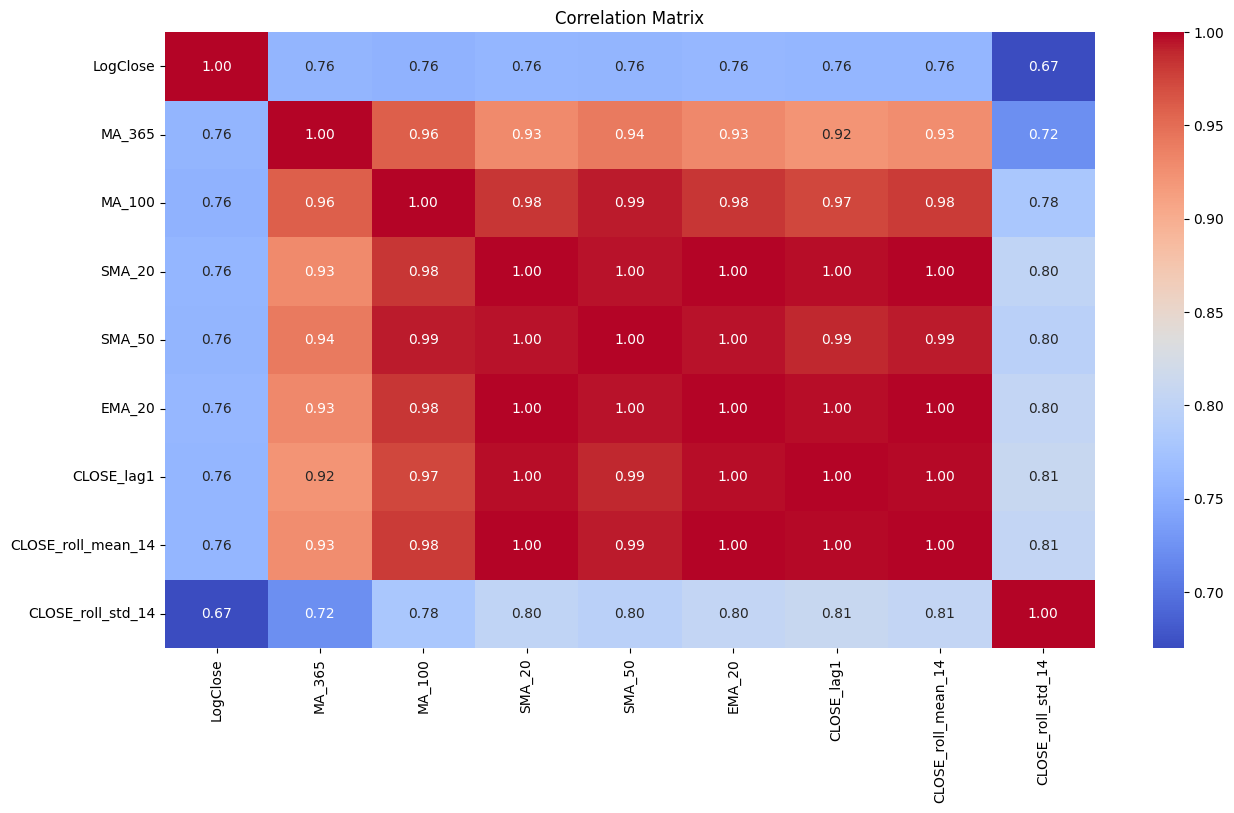

In [64]:
# Compute correlation matrix
correlation_matrix = cleaned_data[feature_cols].corr()

# Visualize correlation
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Data Splitting
## Train-Test Split and Scaling the data

In [65]:
train_frac=0.8
val_frac=0.1

total_samples = len(X_raw)
train_size = int(train_frac * total_samples)
val_size   = int(val_frac * total_samples)

# Train/Val/Test Split
X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]
dates_train = dates[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]
dates_val   = dates[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]
dates_test  = dates[train_size + val_size:]

print(f"X_train_raw: {X_train_raw.shape}, X_val_raw: {X_val_raw.shape}, X_test_raw: {X_test_raw.shape}, y_train_raw: {y_train_raw.shape}, y_val_raw: {y_val_raw.shape}, y_test_raw: {y_test_raw.shape}")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on TRAIN only for features (reshape to 2D for scaling)
X_train_2d = X_train_raw.reshape(-1, X_train_raw.shape[2])
scaler_X.fit(X_train_2d)

X_train_final = scaler_X.transform(X_train_2d).reshape(X_train_raw.shape)
X_val_final  = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[2])).reshape(X_val_raw.shape)
X_test_final  = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[2])).reshape(X_test_raw.shape)

# Scale target values if needed (not returned)
y_train_2d = y_train_raw.reshape(-1, 1)
scaler_y.fit(y_train_2d)
y_train_final = scaler_y.transform(y_train_2d).flatten()
y_val_final  = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
y_test_final  = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

print(f"X_train_scaled: {X_train_final.shape}, X_val_scaled: {X_val_final.shape}, X_test_scaled: {X_test_final.shape}, y_train_scaled: {y_train_final.shape}, y_val_scaled: {y_val_final.shape}, y_test_scaled: {y_test_final.shape}")


X_train_raw: (3684, 30, 9), X_val_raw: (460, 30, 9), X_test_raw: (462, 30, 9), y_train_raw: (3684,), y_val_raw: (460,), y_test_raw: (462,)
X_train_scaled: (3684, 30, 9), X_val_scaled: (460, 30, 9), X_test_scaled: (462, 30, 9), y_train_scaled: (3684,), y_val_scaled: (460,), y_test_scaled: (462,)


# Model Training

In [66]:
l2_reg = tf.keras.regularizers.l2(1e-4)
dropout_rate = 0.3

# Determine window_size and number of features from X_train
window_size = X_train_final.shape[1]
num_features = X_train_final.shape[2]

model = Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.LSTM(
        64,
        return_sequences=True,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),
    layers.Dropout(dropout_rate),
    layers.LSTM(
        64,
        return_sequences=False,
        kernel_regularizer=l2_reg,
        recurrent_regularizer=l2_reg,
        bias_regularizer=l2_reg
    ),  
])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)
 

history = model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=20,
    batch_size=50,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20


2025-05-18 06:52:27.419676: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [50] vs. [50,64]
	 [[{{function_node __inference_one_step_on_data_88051}}{{node compile_loss/mse/sub}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/mse/sub defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3365, in run_cell_async

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3610, in run_ast_nodes

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3670, in run_code

  File "/tmp/ipykernel_2283/2962928635.py", line 37, in <module>

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/losses/losses.py", line 33, in call

  File "/home/karthikponna/kittu/mlops_4_Bitcoin/Bitcoin-price-prediction-MLops/bitcoin/lib/python3.12/site-packages/keras/src/losses/losses.py", line 1679, in mean_squared_error

Incompatible shapes: [50] vs. [50,64]
	 [[{{node compile_loss/mse/sub}}]] [Op:__inference_multi_step_on_iterator_88106]

# Model Evaluation

In [ ]:
train_preds_scaled = model.predict(X_train_final).flatten()
val_preds_scaled = model.predict(X_val_final).flatten()
test_preds_scaled = model.predict(X_test_final).flatten()

train_preds_log = scaler_y.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
val_preds_log = scaler_y.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
test_preds_log = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()

# Convert back from log scale
train_preds = np.expm1(train_preds_log)
val_preds = np.expm1(val_preds_log)
test_preds = np.expm1(test_preds_log)

y_train_log = scaler_y.inverse_transform(y_train_final.reshape(-1, 1)).flatten()
y_val_log = scaler_y.inverse_transform(y_val_final.reshape(-1, 1)).flatten()
y_test_log = scaler_y.inverse_transform(y_test_final.reshape(-1, 1)).flatten()

y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_val_log)
y_test_orig = np.expm1(y_test_log)

# ------------------------------------------------------
#  Evaluation
# ------------------------------------------------------
train_mse = mean_squared_error(y_train_orig, train_preds)
val_mse = mean_squared_error(y_val_orig, val_preds)
test_mse = mean_squared_error(y_test_orig, test_preds)

train_mae = mean_absolute_error(y_train_orig, train_preds)
val_mae = mean_absolute_error(y_val_orig, val_preds)
test_mae = mean_absolute_error(y_test_orig, test_preds)

train_r2 = r2_score(y_train_orig, train_preds)
val_r2 = r2_score(y_val_orig, val_preds)
test_r2 = r2_score(y_test_orig, test_preds)

logging.info("Training Metrics:")
logging.info(f" - MSE: {train_mse:.4f}")
logging.info(f" - MAE: {train_mae:.4f}")
logging.info(f" - R²:  {train_r2:.4f}")

logging.info("Validation Metrics:")
logging.info(f" - MSE: {val_mse:.4f}")
logging.info(f" - MAE: {val_mae:.4f}")
logging.info(f" - R²:  {val_r2:.4f}")

logging.info("Test Metrics:")
logging.info(f" - MSE: {test_mse:.4f}")
logging.info(f" - MAE: {test_mae:.4f}")
logging.info(f" - R²:  {test_r2:.4f}")

metrics = {
    "train": {
        "MSE": train_mse,
        "MAE": train_mae,
        "R-squared": train_r2
    },
    "validation": {
        "MSE": val_mse,
        "MAE": val_mae,
        "R-squared": val_r2
    },
    "test": {
        "MSE": test_mse,
        "MAE": test_mae,
        "R-squared": test_r2
    }
}
print(metrics)

123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'train': {'MSE': 867111.0068830698, 'MAE': 383.01277547871575, 'R-squared': 0.9962334428140279}, 'validation': {'MSE': 688586.909932206, 'MAE': 613.7972066643539, 'R-squared': 0.9868132877003857}, 'test': {'MSE': 70099774.81845285, 'MAE': 6079.521089355684, 'R-squared': 0.7698661965188653}}


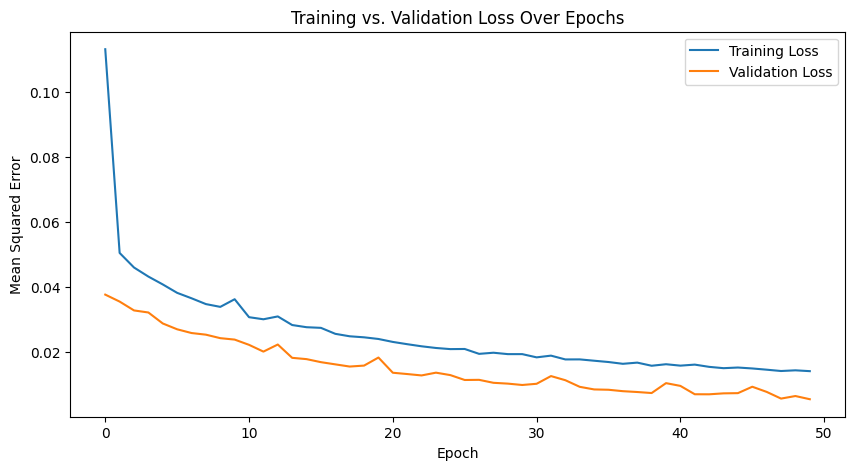

In [ ]:
# Assuming 'history' is the History object returned from model.fit()
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

**Observations:**

1. **Convergence Trend:** Both the training loss and validation loss decrease steadily over time, indicating that the model is learning effectively. By around epoch 100, both losses plateau, suggesting the model has reached optimal performance.

2. **No Overfitting:** The validation loss remains consistently lower than the training loss throughout the epochs. This suggests the model is generalizing well to unseen data without signs of overfitting.


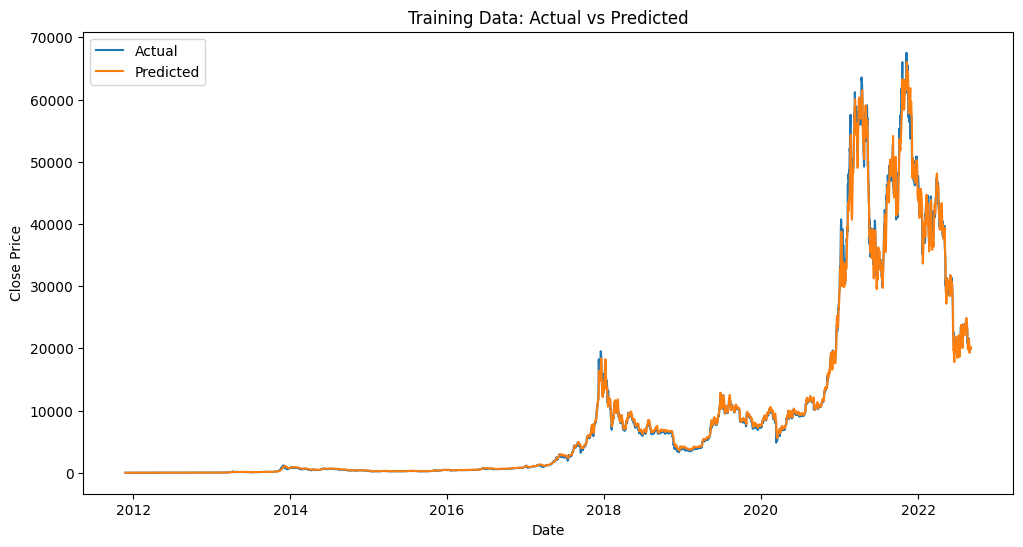

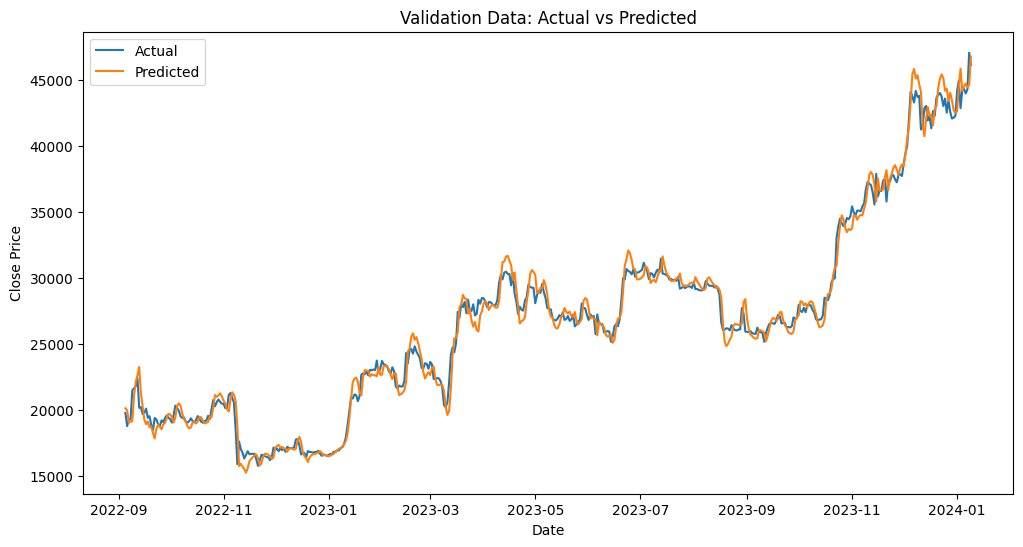

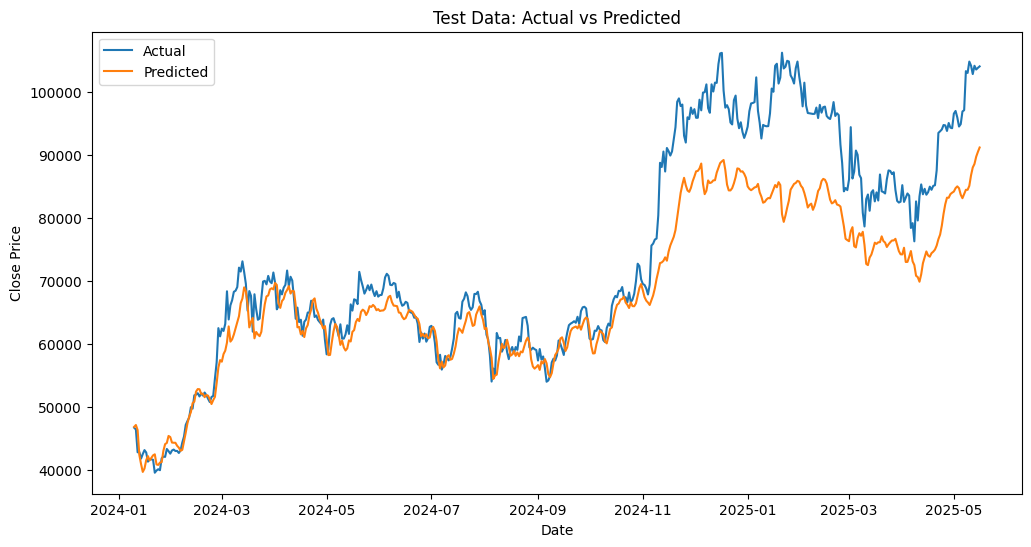

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train_orig, label="Actual")
plt.plot(dates_train, train_preds, label="Predicted")
plt.title("Training Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
# Plot for Validation Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_val, y_val_orig, label="Actual")
plt.plot(dates_val, val_preds, label="Predicted")
plt.title("Validation Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot for Test Data: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_orig, label="Actual")
plt.plot(dates_test, test_preds, label="Predicted")
plt.title("Test Data: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


**Observations:**

1. **Training Data:** The predicted curve closely follows the actual price trend, indicating the model has effectively learned from historical data.

2. **Validation Data:** The model tracks short-term fluctuations well, suggesting it generalizes effectively to unseen data.

3. **Test Data:** Despite some deviations at higher price levels, the predictions still capture the overall upward and downward movements, demonstrating a reasonable forecasting capability.